#### Kaggle 산탄데르 고객 만족 예측(Santander Customer Satisfaction)

- XGBoost와 LightGBM을 활용해서 예측해보자

- 산탄데르 은행이 주최한 경연이라 피처 이름은 익명 처리되어있음

- 레이블값이 1이면 불만 가진 고객, 0이면 만족한 고객

- 모델 성능 평가는 roc-auc로 평가

https://www.kaggle.com/competitions/santander-customer-satisfaction/data

##### 데이터 전처리

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv('/content/train.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [4]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


- 전체 데이터에서 만족, 불만족의 비율 살펴보기

In [5]:
cust_df['TARGET'].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

In [6]:
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

비율은 0.04


In [7]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [8]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

- var3의 min값이 -999999임 >> 116개 있음

- 다른 값에 비해 편차가 심하므로 값이 가장 많은 2로 변환하자

In [9]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

In [10]:
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print(X_features.shape)

(76020, 369)


- 데이터 분리하기
  
  데이터셋이 비대칭이므로 타겟값 분포도가 학습용, 테스트용에 비슷하게 추출됐는지 확인하기

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape, X_test.shape)
print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

(60816, 369) (15204, 369)
0    0.960964
1    0.039036
Name: TARGET, dtype: float64
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


- 원본데이터와 유사하게 타겟값의 분포가 불만족값 4% 정도로 만들어짐

- 조기중단의 검증데이터셋으로 사용하기 위해 다시 한번 데이터 쪼개기

In [12]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

##### XGBoost 모델 학습, 하이퍼 파라미터 튜닝

- 사이킷런 래퍼 XGBoost기반으로 학습 수행하자

- 조기중단은 100회로 설정




In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val,  y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))        

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

- HyperOpt를 이용해 베이지안 최적화 기법으로 튜닝하기


In [21]:
#검색 공간 설정
from hyperopt import hp

xgb_search_space = {'max_depth':hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight':hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2)}

In [27]:
#목적함수 만들기
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          learning_rate=search_space['learning_rate'], 
                          colsample_bytree=search_space['colsample_bytree'])
  roc_auc_list = []

  #3개 kfold 방식 적용
  kf = KFold(n_splits=3)
  #X_train을 다시 학습용, 검증용으로 나누기
  for tr_index, val_index in kf.split(X_train):

    #kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습, 검증데이터셋 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    #조기중단 30회, 추출된 학습, 검증데이터로 학습 수행
    xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val,  y_val)])

    #1로 예측한 확률값 추출 후 roe auc 계산하고 평균 계산을 위해 리스트에 담기
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
    roc_auc_list.append(score)

  return -1 * np.mean( roc_auc_list)

In [36]:
#fmin()함수로 최적 하이퍼 파라미터 도출하기
from hyperopt import fmin, tpe, Trials

trials = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(seed=30))
print('best:', best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: 'num_leaves'


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


KeyError: ignored

In [ ]:
#도출된 하이퍼 파라미터 기반으로 재학습, 예측 수행, ROC AUC 측정
xgb_clf = XGBClassifier(n_estimators=500, max_depth=int(best['max_depth']),
                          min_child_weight=int(best['min_child_weight']),
                          learning_rate=round(best['learning_rate'], 5),
                         colsample_bytree=round(best['colsample_bytree'], 5)

xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val,  y_val)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

- 하이퍼 파라미터 튜닝 후 roc auc가 개선됨

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

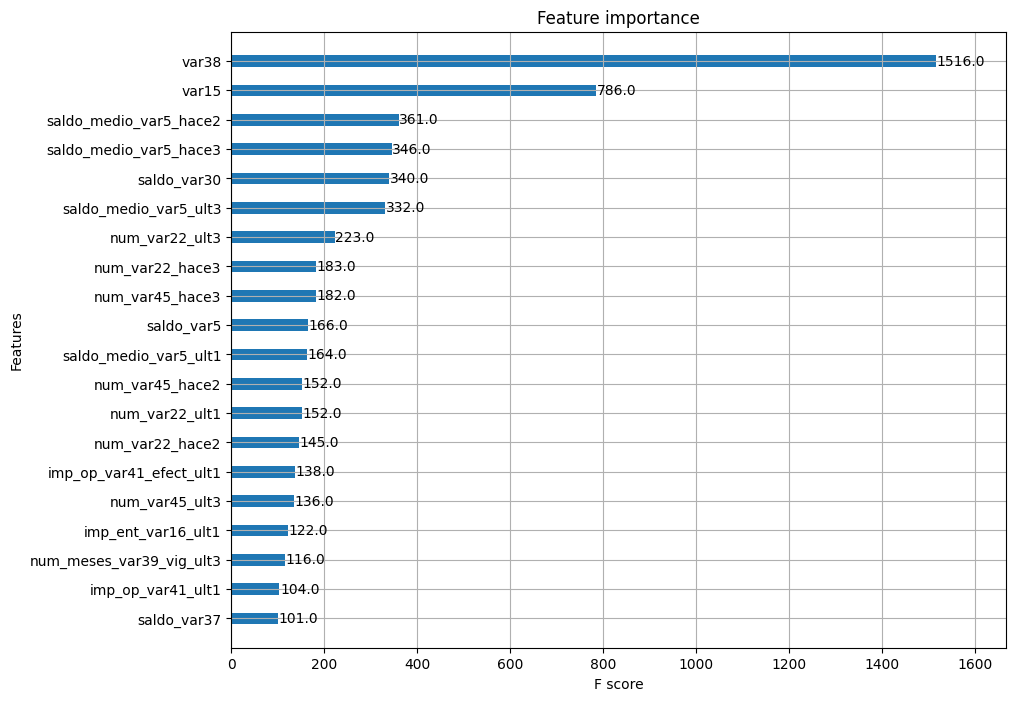

In [30]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

##### LightGBM 모델 학습, 하이퍼 파라미터 튜닝


In [31]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set = [(X_tr, y_tr), (X_val,  y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=eval_set)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

In [32]:
#검색공간 설정
lgbm_search_space = {'num_leaves':hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth':hp.quniform('max_depth', 100, 160, 1),
                    'min_child_samples':hp.quniform('min_child_samples', 60, 100, 1),
                    'subsample':hp.uniform('subsample', 0.7, 1),
                    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2)}

In [34]:
#목적함수 생성
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators=100,
                         num_leaves=int(search_space['num_leaves']), 
                          max_depth=int(search_space['max_depth']),
                          min_child_samples=int(search_space['min_child_samples']),
                          learning_rate=search_space['learning_rate'], 
                          subsample=search_space['subsample'])
  roc_auc_list = []

  #3개 kfold 방식 적용
  kf = KFold(n_splits=3)
  #X_train을 다시 학습용, 검증용으로 나누기
  for tr_index, val_index in kf.split(X_train):

    #kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습, 검증데이터셋 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    #조기중단 30회, 추출된 학습, 검증데이터로 학습 수행
    lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val,  y_val)])

    #1로 예측한 확률값 추출 후 roe auc 계산하고 평균 계산을 위해 리스트에 담기
    score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
    roc_auc_list.append(score)

  return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()
best = fmin(fn=objective_func,
            space=lgbm_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(seed=30))
print('best:', best)

In [39]:
#fmin()호출해서 최적 하이퍼 파라미터 도출
lgbm_clf = LGBMClassifier(n_estimators=500,
                          num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          learning_rate=round(best['learning_rate'], 5),
                         subsample=round(best['subsample'], 5))

lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val,  y_val)])
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.828044	training's binary_logloss: 0.162303	valid_1's auc: 0.810353	valid_1's binary_logloss: 0.163601
[2]	training's auc: 0.830474	training's binary_logloss: 0.160304	valid_1's auc: 0.810645	valid_1's binary_logloss: 0.161911
[3]	training's auc: 0.835072	training's binary_logloss: 0.158517	valid_1's auc: 0.813874	valid_1's binary_logloss: 0.160345
[4]	training's auc: 0.83688	training's binary_logloss: 0.156908	valid_1's auc: 0.814316	valid_1's binary_logloss: 0.158965
[5]	training's auc: 0.838486	training's binary_logloss: 0.155429	valid_1's auc: 0.813951	valid_1's binary_logloss: 0.157694
[6]	training's auc: 0.838918	training's binary_logloss: 0.154044	valid_1's auc: 0.814572	valid_1's binary_logloss: 0.156588
[7]	training's auc: 0.839901	training's binary_logloss: 0.152754	valid_1's auc: 0.814387	valid_1's binary_logloss: 0.155526
[8]	training's auc: 0.841328	training's binary_logloss: 0.151584	valid_1's auc: 0.815482	valid_1's binary_logloss: 0.154537
[9]	train